In [2]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Setting  the parameters
S = 150
K = 150
T_months = 6
T_years = T_months / 12
r = 0.03
sigma = 0.20

# Displaying the parameters
print("-- Parameters --")
print()
print(f"Spot price (S): {S:.2f}")
print(f"Strike (K): {K:.2f}")
print(f"Time to maturity (months): {T_months}")
print(f"Time to maturity (years): {T_years:.2f}")
print(f"Volatility (sigma): {sigma:.2f}")
print(f"Risk-free rate (r): {r:.2f}")

-- Parameters --

Spot price (S): 150.00
Strike (K): 150.00
Time to maturity (months): 6
Time to maturity (years): 0.50
Volatility (sigma): 0.20
Risk-free rate (r): 0.03


In [4]:
# Pricing it with Black-Scholes formula
# Defining Black-Scholes formula
from scipy.stats import norm

def black_scholes(S, K, T_years, r, sigma, option_type):
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T_years) / (np.sqrt(T_years) * sigma)
  d2 = d1 - np.sqrt(T_years) * sigma
  if option_type == "call":
    Price = S * norm.cdf(d1) - K * norm.cdf(d2) * np.exp(-r * T_years)

  elif option_type == "put":
    Price = K * norm.cdf(-d2) * np.exp(-r * T_years) - S * norm.cdf(-d1)

  return Price

# Calculating the put price
P = black_scholes(S, K, T_years, r, sigma, "put")

print("-- Black-Scholes Put Option Pricing Model --")
print()
print(f"Option Valued at: ${P: .2f}")

-- Black-Scholes Put Option Pricing Model --

Option Valued at: $ 7.32


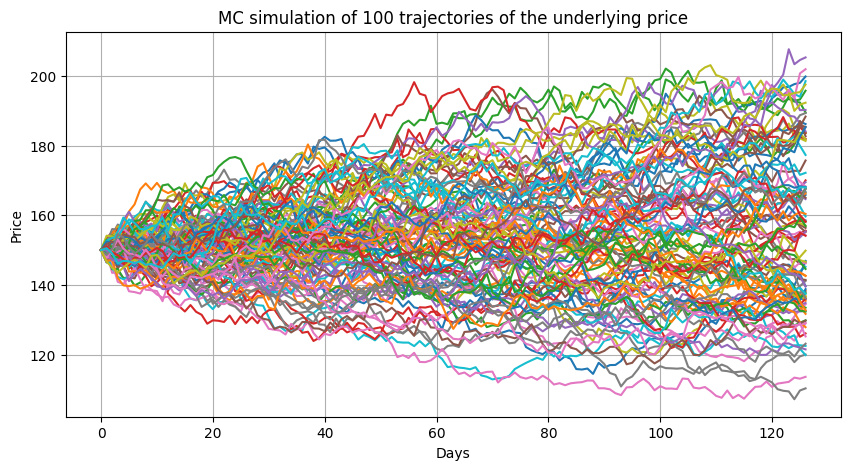

In [5]:
# Pricing the put option with Monte Carlo simulations
# Simulating the price of the underlying
n_paths = 100000
steps_per_year = 252
n_steps = int(T_years * steps_per_year)
dt = T_years / n_steps

Z = np.random.normal(0, 1, size=(n_steps, n_paths)) # common random numbers

paths = np.zeros((n_steps + 1, n_paths))
paths[0] = S

for t in range(1, n_steps + 1):
    paths[t] = paths[t-1] * np.exp((r - 0.5 * sigma**2) * dt
                                  + sigma * np.sqrt(dt) * Z[t-1])

plt.figure(figsize=(10, 5))
plt.plot(paths[:, :100])
plt.title("MC simulation of 100 trajectories of the underlying price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [6]:
# Calculating the value of payoffs
ST = paths[-1]
payoffs = np.maximum(K - ST, 0)
Price = np.average(payoffs) * np.exp(-r * T_years)

# MC standard error
SE = np.std(payoffs, ddof=1) / np.sqrt(n_paths)
SE = SE * np.exp(-r * T_years)
CI_low = Price - 1.96 * SE
CI_high = Price + 1.96 * SE


print("-- Monte Carlo Put Option Pricing Model --")
print()
print(f"Option Valued at: ${Price: .2f}")
print()
print(f"95% Confidence Interval: [${CI_low:.2f}, ${CI_high:.2f}]")


-- Monte Carlo Put Option Pricing Model --

Option Valued at: $ 7.33

95% Confidence Interval: [$7.26, $7.39]


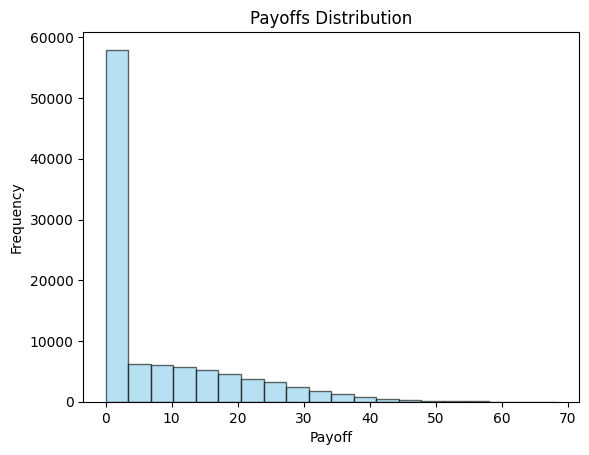

In [7]:
# histogram of payoffs distribution
plt.hist(payoffs, bins=20, density=False, alpha=0.6, color='skyblue', edgecolor='black')

plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.title('Payoffs Distribution')

plt.show()


In [8]:
# Calculating the Greeks
# Using analytical formulas
d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T_years) / (np.sqrt(T_years) * sigma)
d2 = d1 - np.sqrt(T_years) * sigma

delta = norm.cdf(d1) - 1
gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T_years))
vega = S * np.sqrt(T_years) * norm.pdf(d1)
rho = -K * T_years * np.exp(-r * T_years) * norm.cdf(-d2)
theta = (-S * sigma * norm.pdf(d1)) / (2 * np.sqrt(T_years)) \
        + r * K * np.exp(-r * T_years) * norm.cdf(-d2)

print("-- Greeks with analytical formulas --")
print(f"Delta: {delta:.4f}")
print(f"Gamma: {gamma:.4f}")
print(f"Vega: {vega:.4f}")
print(f"Rho: {rho:.4f}")
print(f"Theta: {theta:.4f}")

-- Greeks with analytical formulas --
Delta: -0.4298
Gamma: 0.0185
Vega: 41.6582
Rho: -35.8998
Theta: -6.1777


In [9]:
# Using MC simulations
# Pricing function
Z = np.random.normal(0, 1, n_paths) # common random numbers
def mc_put_price_terminal(S, sigma, T_years, r):
    drift = (r - 0.5 * sigma**2) * T_years
    diff = sigma * np.sqrt(T_years) * Z

    ST = S * np.exp(drift + diff)
    payoffs = np.maximum(K - ST, 0)

    return np.exp(-r * T_years) * np.mean(payoffs)

Price0 = mc_put_price_terminal(S, sigma, T_years, r)

# bumps size
hS = 1.0
hsigma = 0.005
hT = 1/252
hr = 0.001

# Terminal simulated prices
Price_d_up = mc_put_price_terminal(S + hS, sigma, T_years, r)
Price_d_down = mc_put_price_terminal(S - hS, sigma, T_years, r)
Price_v_up = mc_put_price_terminal(S, sigma + hsigma, T_years, r)
Price_v_down = mc_put_price_terminal(S, sigma - hsigma, T_years, r)
Price_t_up = mc_put_price_terminal(S, sigma, T_years + hT, r)
Price_t_down = mc_put_price_terminal(S, sigma, T_years - hT, r)
Price_r_up = mc_put_price_terminal(S, sigma, T_years, r + hr)
Price_r_down = mc_put_price_terminal(S, sigma, T_years, r - hr)

# Central-finite differences
delta = (Price_d_up - Price_d_down) / (2 * hS)
gamma = (Price_d_up - 2 * Price0 + Price_d_down) / (hS**2)
vega = (Price_v_up - Price_v_down) / (2 * hsigma)
rho = (Price_r_up - Price_r_down) / (2 * hr)
theta = (Price_t_up - Price_t_down) / (2 * hT)

print("--  MC Greeks (Central-finite differences) --")
print(f"Delta_MC: {delta:.4f}")
print(f"Gamma_MC: {gamma:.4f}")
print(f"Vega_MC : {vega:.4f}")
print(f"Rho_MC  : {rho:.4f}")
print(f"Theta_MC: {theta:.4f}")


--  MC Greeks (Central-finite differences) --
Delta_MC: -0.4303
Gamma_MC: 0.0183
Vega_MC : 41.6842
Rho_MC  : -35.9292
Theta_MC: 6.1812


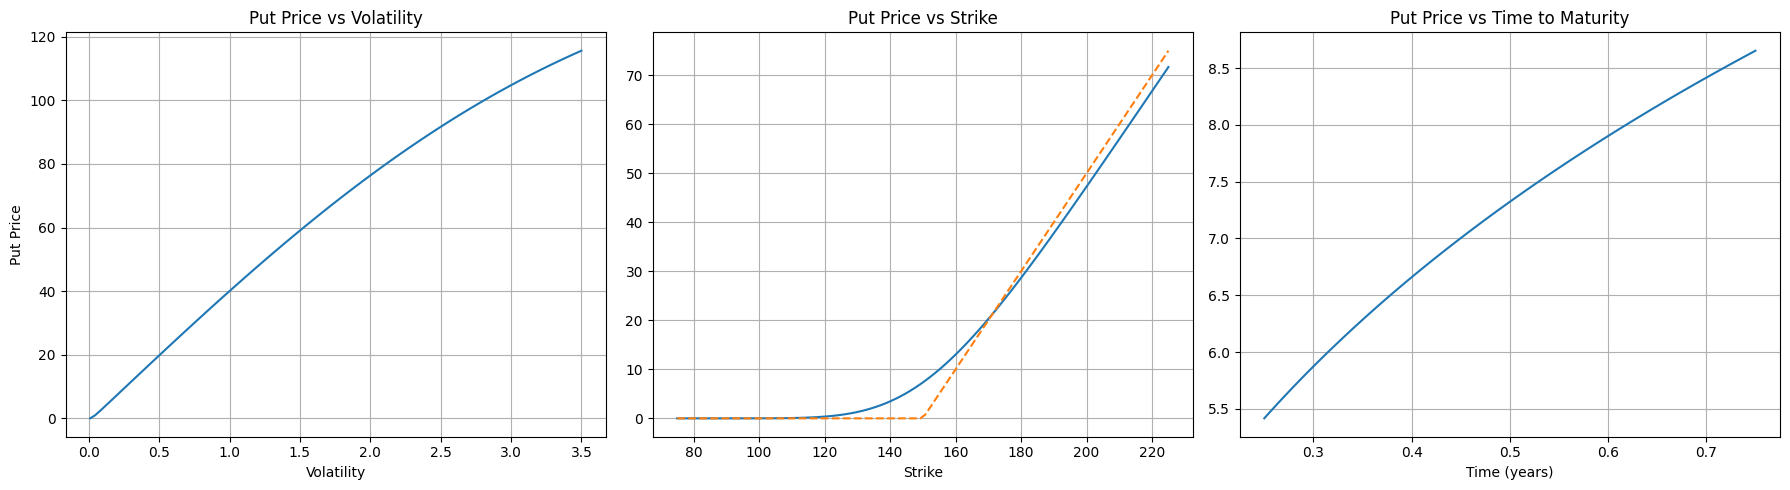

In [10]:
# sensitivity analysis
sigmas = np.linspace(0.01, 3.5, 100)
Ks = np.linspace(K * 0.5, K * 1.5, 100)
Ts = np.linspace(T_years * 0.5, T_years * 1.5, 100)

P_sigma = black_scholes(S, K, T_years, r, sigmas, "put")
P_K = black_scholes(S, Ks, T_years, r, sigma, "put")
P_T = black_scholes(S, K, Ts, r, sigma, "put")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(sigmas, P_sigma)
axs[0].set_title("Put Price vs Volatility")
axs[0].set_xlabel("Volatility")
axs[0].set_ylabel("Put Price")
axs[0].grid(True)

axs[1].plot(Ks, P_K)
axs[1].plot(Ks, np.maximum(Ks - S, 0), linestyle="--", label="Payoff")
axs[1].set_title("Put Price vs Strike")
axs[1].set_xlabel("Strike")
axs[1].grid(True)

axs[2].plot(Ts, P_T)
axs[2].set_title("Put Price vs Time to Maturity")
axs[2].set_xlabel("Time (years)")
axs[2].grid(True)

plt.tight_layout()
plt.show()
